<a href="https://colab.research.google.com/github/sudhakarmlal/EVA4/blob/master/EVA4/Session9/models/S9_Misclassified_Ver10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S9
In this assignment Resnet architecture is used to train CIPHAR10 dataset. Developed APIs so as to load data, train, test and show results.

Following changes are done:
1. Dropout is added to the Base ResNet18 model
2. Added random cropping Image augmentation 
3. Added L2 regularization


In [0]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-49bv34oe
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-49bv34oe
     |████████████████████████████████| 634kB 12.6MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=c94bea588a74adee985dc45696fec683d7e63ee347ace052c6c28efe5917006f
  Stored in directory: /tmp/pip-ephem-wheel-cache-699uc2qf/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=7c8ccc09f8adf0ba889d84a8dc6bdfd727629604e1b0deb34f0a360f8ea5e055
  Stored in directory: /tmp/pip-ephem-wheel-cache-699uc2qf/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albu

## Mount the google drive

In [3]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp -rf '/content/drive/My Drive/data_loaders' .
!cp -rf '/content/drive/My Drive/data_transformations' .
!cp -rf '/content/drive/My Drive/models' .
!cp -rf '/content/drive/My Drive/utils' .

## Import all the libraries

In [0]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_ciphar10_resnet import get_train_transform, get_test_transform
from data_loaders.ciphar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.resnet18 import ResNet18
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy
from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcam_utils import process_grad
from utils.gradcamkz_util import demo2




In [0]:
conter = 1


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [6]:
transform_train = get_train_transform()
transform_test = get_test_transform()

trainloader = get_train_loader(256, transform_train)
testloader = get_test_loader(256, transform_test)
classes = get_classes()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing some of the images in train dataset



## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         Dropout2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 30 epochs to train the model

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [0]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  ResNet18().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

EPOCHS = 75
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch, train_losses,train_acc )
    test(model, device, testloader, test_losses, test_acc)
    scheduler.step()

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=1.2453465461730957 Batch_id=195 Accuracy=42.86: 100%|██████████| 196/196 [00:57<00:00,  3.39it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.3597, Accuracy: 5083/10000 (50.83%)

EPOCH: 1


Loss=1.0610466003417969 Batch_id=195 Accuracy=59.93: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9217, Accuracy: 6914/10000 (69.14%)

EPOCH: 2


Loss=0.7503864765167236 Batch_id=195 Accuracy=67.91: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.9097, Accuracy: 7092/10000 (70.92%)

EPOCH: 3


Loss=0.7483682036399841 Batch_id=195 Accuracy=72.24: 100%|██████████| 196/196 [01:01<00:00,  3.21it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7099, Accuracy: 7590/10000 (75.90%)

EPOCH: 4


Loss=0.7241926193237305 Batch_id=195 Accuracy=75.29: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7928, Accuracy: 7497/10000 (74.97%)

EPOCH: 5


Loss=0.6553255915641785 Batch_id=195 Accuracy=77.70: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7418, Accuracy: 7597/10000 (75.97%)

EPOCH: 6


Loss=0.8961033821105957 Batch_id=195 Accuracy=80.05: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8168, Accuracy: 7573/10000 (75.73%)

EPOCH: 7


Loss=0.4408499300479889 Batch_id=195 Accuracy=81.39: 100%|██████████| 196/196 [01:00<00:00,  3.21it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6740, Accuracy: 7999/10000 (79.99%)

EPOCH: 8


Loss=0.5904747247695923 Batch_id=195 Accuracy=82.80: 100%|██████████| 196/196 [01:01<00:00,  3.21it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8742, Accuracy: 7631/10000 (76.31%)

EPOCH: 9


Loss=0.436629056930542 Batch_id=195 Accuracy=83.66: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8866, Accuracy: 7595/10000 (75.95%)

EPOCH: 10


Loss=0.4602954387664795 Batch_id=195 Accuracy=84.38: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7051, Accuracy: 8148/10000 (81.48%)

EPOCH: 11


Loss=0.37249088287353516 Batch_id=195 Accuracy=84.86: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7262, Accuracy: 8074/10000 (80.74%)

EPOCH: 12


Loss=0.3288920521736145 Batch_id=195 Accuracy=85.67: 100%|██████████| 196/196 [01:00<00:00,  3.27it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7494, Accuracy: 8027/10000 (80.27%)

EPOCH: 13


Loss=0.6013056635856628 Batch_id=195 Accuracy=86.35: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6798, Accuracy: 8104/10000 (81.04%)

EPOCH: 14


Loss=0.37160858511924744 Batch_id=195 Accuracy=86.57: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7254, Accuracy: 8130/10000 (81.30%)

EPOCH: 15


Loss=0.4939005970954895 Batch_id=195 Accuracy=88.24: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5205, Accuracy: 8542/10000 (85.42%)

EPOCH: 16


Loss=0.4241052269935608 Batch_id=195 Accuracy=88.51: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5158, Accuracy: 8589/10000 (85.89%)

EPOCH: 17


Loss=0.32871562242507935 Batch_id=195 Accuracy=88.51: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5036, Accuracy: 8606/10000 (86.06%)

EPOCH: 18


Loss=0.37051060795783997 Batch_id=195 Accuracy=88.62: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5023, Accuracy: 8599/10000 (85.99%)

EPOCH: 19


Loss=0.30792585015296936 Batch_id=195 Accuracy=88.51: 100%|██████████| 196/196 [01:00<00:00,  3.27it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5013, Accuracy: 8601/10000 (86.01%)

EPOCH: 20


Loss=0.26263388991355896 Batch_id=195 Accuracy=88.50: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4907, Accuracy: 8610/10000 (86.10%)

EPOCH: 21


Loss=0.2668597102165222 Batch_id=195 Accuracy=88.98: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4983, Accuracy: 8602/10000 (86.02%)

EPOCH: 22


Loss=0.41998258233070374 Batch_id=195 Accuracy=89.00: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5002, Accuracy: 8621/10000 (86.21%)

EPOCH: 23


Loss=0.10591515153646469 Batch_id=195 Accuracy=89.01: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 8620/10000 (86.20%)

EPOCH: 24


Loss=0.24631109833717346 Batch_id=195 Accuracy=89.06: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5069, Accuracy: 8620/10000 (86.20%)

EPOCH: 25


Loss=0.2551497519016266 Batch_id=195 Accuracy=88.80: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4997, Accuracy: 8635/10000 (86.35%)

EPOCH: 26


Loss=0.24384748935699463 Batch_id=195 Accuracy=89.26: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5004, Accuracy: 8631/10000 (86.31%)

EPOCH: 27


Loss=0.1594606339931488 Batch_id=195 Accuracy=88.84: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4936, Accuracy: 8637/10000 (86.37%)

EPOCH: 28


Loss=0.26942557096481323 Batch_id=195 Accuracy=88.92: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5002, Accuracy: 8626/10000 (86.26%)

EPOCH: 29


Loss=0.26697519421577454 Batch_id=195 Accuracy=89.04: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5022, Accuracy: 8613/10000 (86.13%)

EPOCH: 30


Loss=0.3801916241645813 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5032, Accuracy: 8624/10000 (86.24%)

EPOCH: 31


Loss=0.15767361223697662 Batch_id=195 Accuracy=88.93: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4972, Accuracy: 8634/10000 (86.34%)

EPOCH: 32


Loss=0.15687295794487 Batch_id=195 Accuracy=89.08: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4950, Accuracy: 8628/10000 (86.28%)

EPOCH: 33


Loss=0.3220251798629761 Batch_id=195 Accuracy=89.30: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4980, Accuracy: 8624/10000 (86.24%)

EPOCH: 34


Loss=0.2736052870750427 Batch_id=195 Accuracy=89.46: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4939, Accuracy: 8643/10000 (86.43%)

EPOCH: 35


Loss=0.29220715165138245 Batch_id=195 Accuracy=89.25: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4922, Accuracy: 8647/10000 (86.47%)

EPOCH: 36


Loss=0.21199288964271545 Batch_id=195 Accuracy=89.18: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4914, Accuracy: 8645/10000 (86.45%)

EPOCH: 37


Loss=0.2283848226070404 Batch_id=195 Accuracy=89.30: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4964, Accuracy: 8658/10000 (86.58%)

EPOCH: 38


Loss=0.28772643208503723 Batch_id=195 Accuracy=89.27: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4962, Accuracy: 8655/10000 (86.55%)

EPOCH: 39


Loss=0.19569234549999237 Batch_id=195 Accuracy=89.07: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4936, Accuracy: 8649/10000 (86.49%)

EPOCH: 40


Loss=0.22793786227703094 Batch_id=195 Accuracy=89.33: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4913, Accuracy: 8647/10000 (86.47%)

EPOCH: 41


Loss=0.25079211592674255 Batch_id=195 Accuracy=89.34: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4947, Accuracy: 8631/10000 (86.31%)

EPOCH: 42


Loss=0.2854495048522949 Batch_id=195 Accuracy=89.09: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4960, Accuracy: 8650/10000 (86.50%)

EPOCH: 43


Loss=0.20491071045398712 Batch_id=195 Accuracy=89.29: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4932, Accuracy: 8654/10000 (86.54%)

EPOCH: 44


Loss=0.22697600722312927 Batch_id=195 Accuracy=89.02: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4951, Accuracy: 8654/10000 (86.54%)

EPOCH: 45


Loss=0.3107057213783264 Batch_id=195 Accuracy=89.12: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4939, Accuracy: 8646/10000 (86.46%)

EPOCH: 46


Loss=0.3300183415412903 Batch_id=195 Accuracy=89.49: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4905, Accuracy: 8660/10000 (86.60%)

EPOCH: 47


Loss=0.23889479041099548 Batch_id=195 Accuracy=89.41: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4945, Accuracy: 8644/10000 (86.44%)

EPOCH: 48


Loss=0.25916722416877747 Batch_id=195 Accuracy=89.32: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4918, Accuracy: 8641/10000 (86.41%)

EPOCH: 49


Loss=0.3886570930480957 Batch_id=195 Accuracy=89.19: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4971, Accuracy: 8658/10000 (86.58%)

EPOCH: 50


Loss=0.1337786316871643 Batch_id=195 Accuracy=89.26: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4899, Accuracy: 8641/10000 (86.41%)

EPOCH: 51


Loss=0.37519392371177673 Batch_id=195 Accuracy=89.45: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4948, Accuracy: 8645/10000 (86.45%)

EPOCH: 52


Loss=0.4449654519557953 Batch_id=195 Accuracy=89.24: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4955, Accuracy: 8642/10000 (86.42%)

EPOCH: 53


Loss=0.26556622982025146 Batch_id=195 Accuracy=89.05: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4947, Accuracy: 8652/10000 (86.52%)

EPOCH: 54


Loss=0.17262449860572815 Batch_id=195 Accuracy=89.29: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4931, Accuracy: 8655/10000 (86.55%)

EPOCH: 55


Loss=0.2861834466457367 Batch_id=195 Accuracy=89.34: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4935, Accuracy: 8650/10000 (86.50%)

EPOCH: 56


Loss=0.4003596901893616 Batch_id=195 Accuracy=89.27: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4986, Accuracy: 8649/10000 (86.49%)

EPOCH: 57


Loss=0.3656602203845978 Batch_id=195 Accuracy=89.33: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4955, Accuracy: 8658/10000 (86.58%)

EPOCH: 58


Loss=0.31622910499572754 Batch_id=195 Accuracy=89.37: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4930, Accuracy: 8654/10000 (86.54%)

EPOCH: 59


Loss=0.2520321011543274 Batch_id=195 Accuracy=89.15: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4930, Accuracy: 8647/10000 (86.47%)

EPOCH: 60


Loss=0.39437752962112427 Batch_id=195 Accuracy=89.39: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4946, Accuracy: 8642/10000 (86.42%)

EPOCH: 61


Loss=0.2873154282569885 Batch_id=195 Accuracy=89.55: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4929, Accuracy: 8647/10000 (86.47%)

EPOCH: 62


Loss=0.1701618731021881 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4907, Accuracy: 8644/10000 (86.44%)

EPOCH: 63


Loss=0.36235228180885315 Batch_id=195 Accuracy=89.36: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4941, Accuracy: 8657/10000 (86.57%)

EPOCH: 64


Loss=0.1718384325504303 Batch_id=195 Accuracy=89.43: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4906, Accuracy: 8651/10000 (86.51%)

EPOCH: 65


Loss=0.14387059211730957 Batch_id=195 Accuracy=89.36: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4954, Accuracy: 8651/10000 (86.51%)

EPOCH: 66


Loss=0.4061112403869629 Batch_id=195 Accuracy=89.32: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4937, Accuracy: 8640/10000 (86.40%)

EPOCH: 67


Loss=0.36323896050453186 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4960, Accuracy: 8652/10000 (86.52%)

EPOCH: 68


Loss=0.2508504092693329 Batch_id=195 Accuracy=89.22: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4922, Accuracy: 8657/10000 (86.57%)

EPOCH: 69


Loss=0.3225252032279968 Batch_id=195 Accuracy=89.24: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4922, Accuracy: 8653/10000 (86.53%)

EPOCH: 70


Loss=0.5991175174713135 Batch_id=195 Accuracy=89.43: 100%|██████████| 196/196 [01:00<00:00,  3.26it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4969, Accuracy: 8656/10000 (86.56%)

EPOCH: 71


Loss=0.2278672158718109 Batch_id=195 Accuracy=89.24: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4925, Accuracy: 8652/10000 (86.52%)

EPOCH: 72


Loss=0.33621394634246826 Batch_id=195 Accuracy=89.14: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4976, Accuracy: 8653/10000 (86.53%)

EPOCH: 73


Loss=0.2331354171037674 Batch_id=195 Accuracy=89.37: 100%|██████████| 196/196 [01:00<00:00,  3.25it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4912, Accuracy: 8650/10000 (86.50%)

EPOCH: 74


Loss=0.3258139491081238 Batch_id=195 Accuracy=89.24: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s]



Test set: Average loss: 0.4936, Accuracy: 8658/10000 (86.58%)



In [0]:
import os

PATH = '/content/drive/My Drive/saved_model/cifar_res_88.pth'
torch.save(model.state_dict(), PATH)
#resnet.load_state_dict(torch.load(PATH))

## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


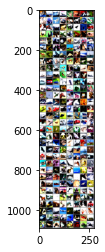

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 86.58 %


The accuracy 84.46 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 81 %
Accuracy of   car : 92 %
Accuracy of  bird : 92 %
Accuracy of   cat : 59 %
Accuracy of  deer : 76 %
Accuracy of   dog : 73 %
Accuracy of  frog : 77 %
Accuracy of horse : 100 %
Accuracy of  ship : 95 %
Accuracy of truck : 88 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Loss
ii. Training Accuracy
iii. Test Loss
iv. Test Accuracy

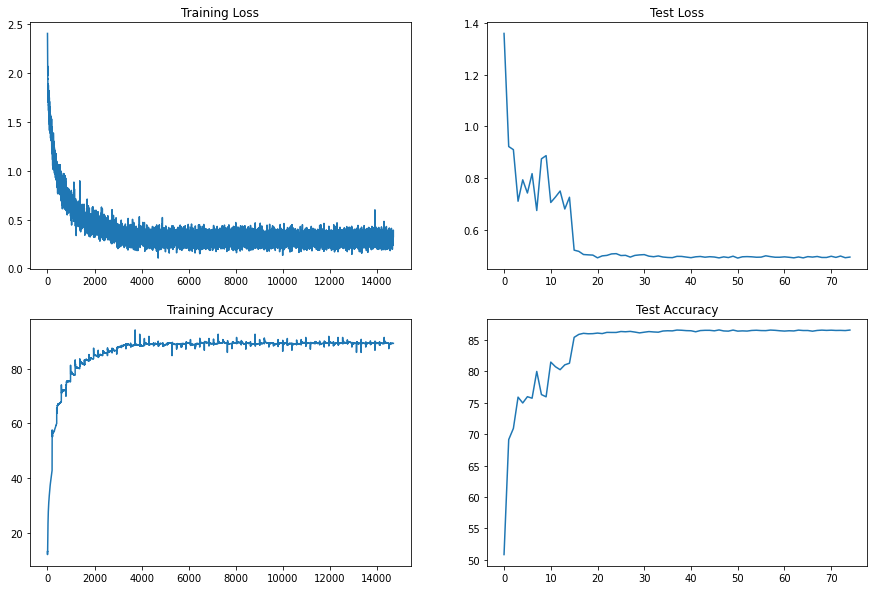

In [0]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

In [0]:
incorrect_image_list =[]
predicted_label_list =[]
correct_label_list = []
for (i, [data, target]) in enumerate(testloader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True).squeeze(1)         
    idxs_mask = (pred !=  target).view(-1)
    img_nm = data[idxs_mask].cpu().numpy()
    img_nm = img_nm.reshape(img_nm.shape[0], 3, 32, 32)
    if img_nm.shape[0] > 0:
        img_list = [img_nm[i] for i in range(img_nm.shape[0])]
        incorrect_image_list.extend(img_list)
        predicted_label_list.extend(pred[idxs_mask].detach().cpu().numpy())
        correct_label_list.extend(target[idxs_mask].detach().cpu().numpy())

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## Display Misclassified Images

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

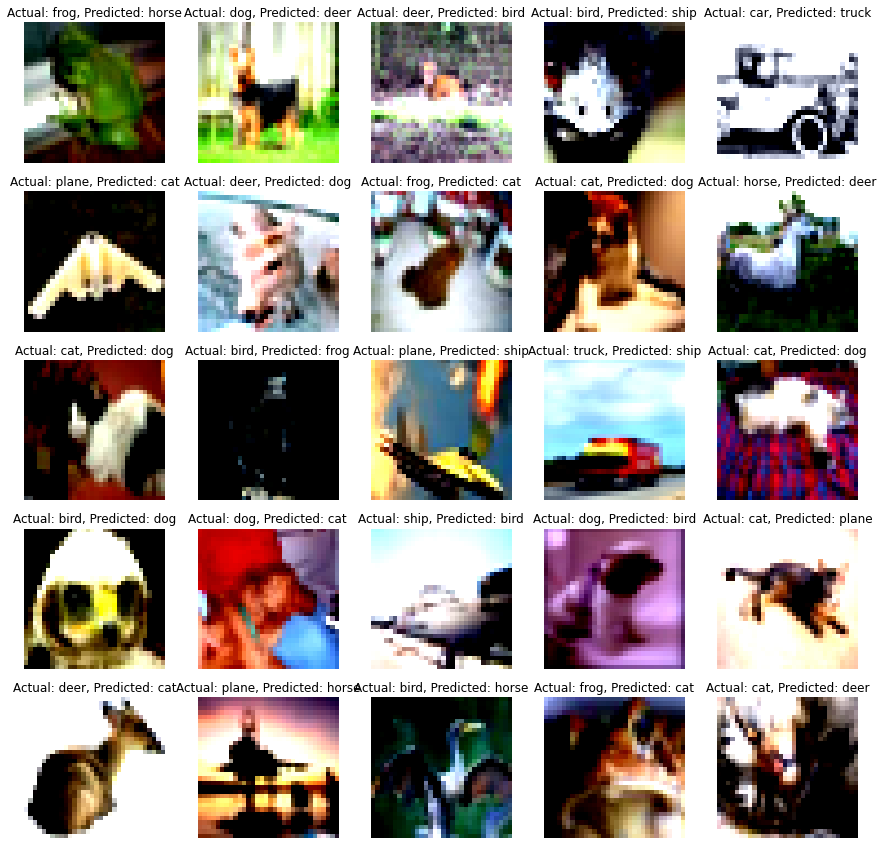

In [0]:
display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18().to(device)

In [0]:
#import os
#os.chdir('/content/drive/My Drive/saved_model')

In [0]:
PATH ='/content/drive/My Drive/saved_model/cifar_res_88.pth'

In [9]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
#!cp -rf '/content/drive/My Drive/eva4_apis/utils' .

In [0]:
#from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for im

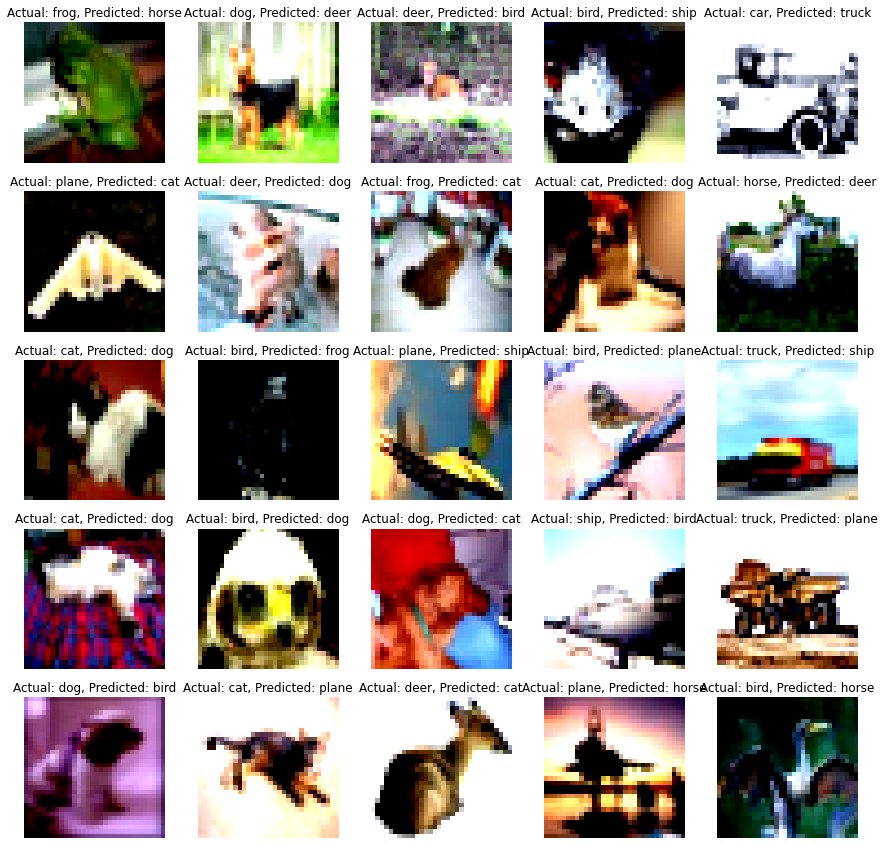

In [0]:
incorrect_images_list,predicted_label_list,correct_label_list=display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)

In [0]:
for i in range(25):
  print("Predicted is",predicted_label_list[i])
  print("Correct is",correct_label_list[i])

Predicted is 7
Correct is 6
Predicted is 4
Correct is 5
Predicted is 2
Correct is 4
Predicted is 8
Correct is 2
Predicted is 9
Correct is 1
Predicted is 3
Correct is 0
Predicted is 5
Correct is 4
Predicted is 3
Correct is 6
Predicted is 5
Correct is 3
Predicted is 4
Correct is 7
Predicted is 5
Correct is 3
Predicted is 6
Correct is 2
Predicted is 8
Correct is 0
Predicted is 0
Correct is 2
Predicted is 8
Correct is 9
Predicted is 5
Correct is 3
Predicted is 5
Correct is 2
Predicted is 3
Correct is 5
Predicted is 2
Correct is 8
Predicted is 0
Correct is 9
Predicted is 2
Correct is 5
Predicted is 0
Correct is 3
Predicted is 3
Correct is 4
Predicted is 7
Correct is 0
Predicted is 7
Correct is 2


In [0]:
len(incorrect_images_list[0:25])

25

In [0]:
incorrect_images_disp  = incorrect_images_list[0:25]

In [0]:
predicted_label_list = predicted_label_list[0:25]

In [0]:
correct_label_list = predicted_label_list[0:25]

In [0]:
#import os
#os.chdir('/content/drive/My Drive/GRAD')

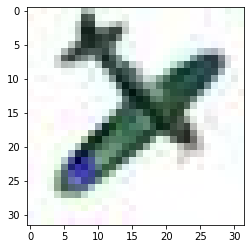

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
img = cv2.imread('/content/drive/My Drive/GRAD/0009.jpg', 1)
#img2 = cv2.imread('./cat.jpg', 0)
#img3 = cv2.imread('./dog.jpg', 0)
plt.imshow(img)
images =[]
images.append(img)
#incorrect_images_disp = []
#incorrect_images_disp.append(img)
#cam_images=process_grad(incorrect_images_disp,model)
#plt.imshow(cam_images[0])

In [13]:
!ls '/content/drive/My Drive/GRAD/'

0005.jpg  0009.jpg


In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
gradimages=demo2(model,images,'/content/drive/My Drive/GRAD/',device,classes)

Images:


RuntimeError: ignored

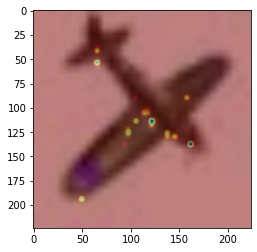

In [12]:
plt.imshow(gradimages[0])

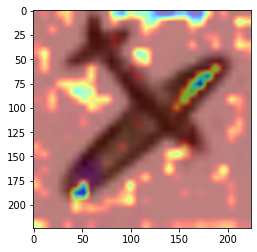

In [13]:
plt.imshow(gradimages[1])

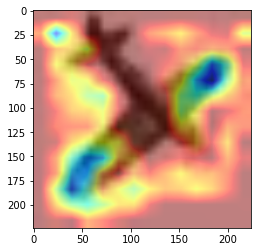

In [14]:
plt.imshow(gradimages[2])

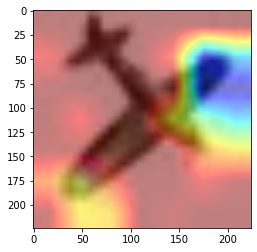

In [15]:
plt.imshow(gradimages[3])

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

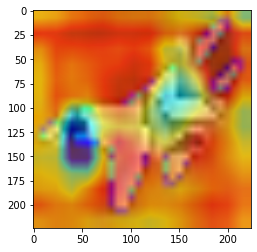

In [0]:
#img = images[10] / 2 + 0.5     # unnormalize
#npimg = img.numpy()
#act_image = np.transpose(npimg, (1, 2, 0))

#testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,  download=True,transform_test)
#testloader2 = torch.utils.data.DataLoader(testset2, batch_size=16,  shuffle=False, num_workers=2)
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[15] 
#img = img * 0.1
#img = img + 0.5

img = images[10] / 2 + 0.5
img = img.numpy()
img=np.transpose(img, (1, 2, 0))
img=np.uint8(img*255)
#plt.imshow(images[0])
#img = img - np.mean(img)
#img = img / (np.std(img) + 1e-5)
#img = img * 0.1
#img = img + 0.5
#img = np.clip(img, 0, 1)
img=np.uint8(img*255)
plt.imshow(img)
incorrect_images_disp = []
incorrect_images_disp.append(img)
cam_images=process_grad(incorrect_images_disp,model)
plt.imshow(cam_images[0])

#plt.imshow(images[0])

The predicted is 7
The correct is 6
The predicted is 4
The correct is 5
The predicted is 2
The correct is 4
The predicted is 8
The correct is 2
The predicted is 9
The correct is 1
The predicted is 3
The correct is 0
The predicted is 5
The correct is 4
The predicted is 3
The correct is 6
The predicted is 5
The correct is 3
The predicted is 4
The correct is 7
The predicted is 5
The correct is 3
The predicted is 6
The correct is 2
The predicted is 8
The correct is 0
The predicted is 0
The correct is 2
The predicted is 8
The correct is 9
The predicted is 5
The correct is 3
The predicted is 5
The correct is 2
The predicted is 3
The correct is 5
The predicted is 2
The correct is 8
The predicted is 0
The correct is 9
The predicted is 2
The correct is 5
The predicted is 0
The correct is 3
The predicted is 3
The correct is 4
The predicted is 7
The correct is 0
The predicted is 7
The correct is 2
25
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 

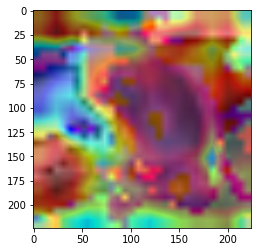

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
#dataiter = iter(testloader)
#images, labels = dataiter.next()
#img = images[15] 
#img = img * 0.1
#img = img + 0.5

#img = images[10] / 2 + 0.5
#img = img.numpy()
#img=np.transpose(img, (1, 2, 0))
#img=np.uint8(img*255)
incorrect_images = []
correct_lb =[]
predicted_lb = []
for i in range(25) :
  img = incorrect_images_disp[i]
  img = img / 2 + 0.5
  img = img
  img=np.transpose(img, (1, 2, 0))
  img=np.uint8(img*255)
  incorrect_images.append(img)
  predicted_lb.append(predicted_label_list[i])
  print("The predicted is",predicted_label_list[i])
  correct_lb.append(correct_label_list[i])
  print("The correct is",correct_label_list[i])
print(len(incorrect_images))
cam_images=process_grad(incorrect_images,model)
plt.imshow(cam_images[0])


#plt.imshow(images[0])
#img = img - np.mean(img)
#img = img / (np.std(img) + 1e-5)
#img = img * 0.1
#img = img + 0.5
#img = np.clip(img, 0, 1)
#img=img*255
#plt.imshow(img)


#plt.imshow(images[0])

In [0]:
def imshow1(img):
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    plt.imshow(np.transpose(img, (1,2, 0)))

In [0]:
print(len(cam_images))

25


In [0]:
for i in range(25):
  print("Predicted is",predicted_lb[i])
  print("Correct is",correct_lb[i])

Predicted is 7
Correct is 6
Predicted is 4
Correct is 5
Predicted is 2
Correct is 4
Predicted is 8
Correct is 2
Predicted is 9
Correct is 1
Predicted is 3
Correct is 0
Predicted is 5
Correct is 4
Predicted is 3
Correct is 6
Predicted is 5
Correct is 3
Predicted is 4
Correct is 7
Predicted is 5
Correct is 3
Predicted is 6
Correct is 2
Predicted is 8
Correct is 0
Predicted is 0
Correct is 2
Predicted is 8
Correct is 9
Predicted is 5
Correct is 3
Predicted is 5
Correct is 2
Predicted is 3
Correct is 5
Predicted is 2
Correct is 8
Predicted is 0
Correct is 9
Predicted is 2
Correct is 5
Predicted is 0
Correct is 3
Predicted is 3
Correct is 4
Predicted is 7
Correct is 0
Predicted is 7
Correct is 2


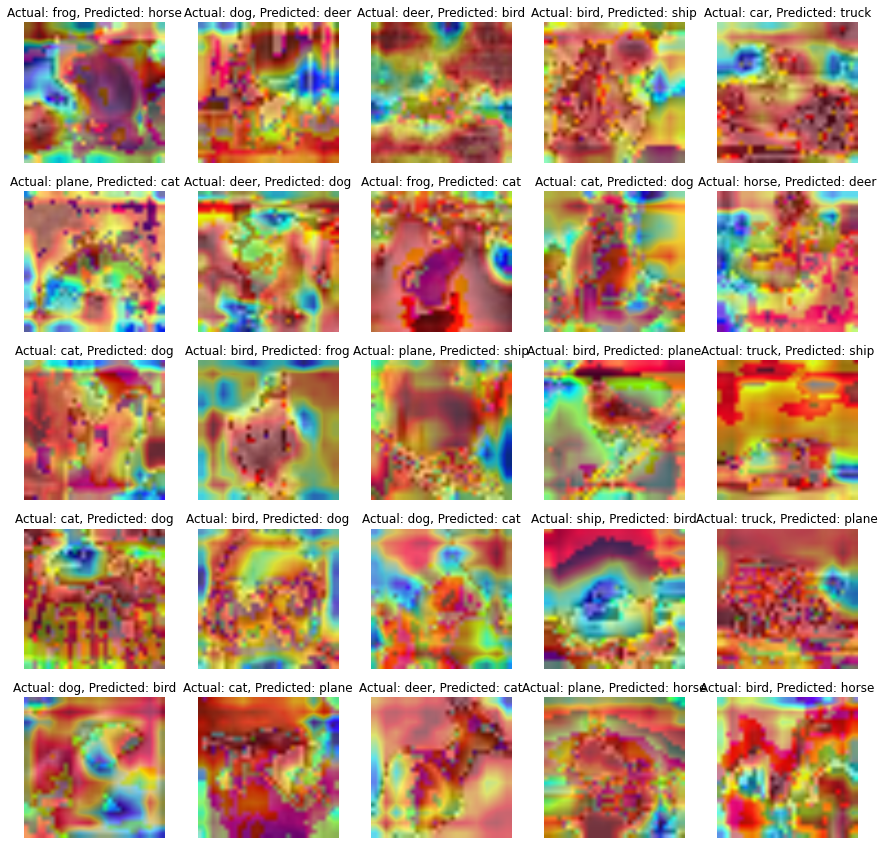

In [0]:
plt.figure(figsize=(15,15))
columns = 5
i= 0
    # Display the list of 25 misclassified images
for index, image in enumerate(cam_images) :
  ax = plt.subplot(5, 5, i+1)
  ax.set_title("Actual: " + str(classes[correct_lb[index]]) + ", Predicted: " + str(classes[predicted_lb[index]]))
  ax.axis('off')
    #plt.imshow(image)
  plt.imshow(image)
  i +=1
  if i==25:
    break

In [0]:
counter  = 0
for (i, [data, target]) in enumerate(testloader):
        print(len(data))
        #img = data[10] / 2 + 0.5
        #img = img.numpy()
        #img=np.transpose(img, (1, 2, 0))
        #img=np.uint8(img*255)
        #plt.imshow(img)
        

256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
16


In [0]:
import os
os.chdir('/content/drive/My Drive/GRAD')

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('gradcamvgg.py','wb').write(src)
import gradcamvgg

Saving gradcamvgg.py to gradcamvgg (2).py


In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
img = cv2.imread('./0009.jpg', 1)
#img2 = cv2.imread('./cat.jpg', 0)
#img3 = cv2.imread('./dog.jpg', 0)
#plt.imshow(img)
incorrect_images_disp = []
incorrect_images_disp.append(img)
gradcamvgg.process_grad(incorrect_images_disp,model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

TypeError: ignored